In [74]:
import os
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

from typing import Sequence, Literal

In [75]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "conflict-coach"

In [76]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=.6)

In [77]:
llm.invoke([HumanMessage(content="Hello, how are you?")])

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 13, 'total_tokens': 43, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-BZnKn9anoFs85uL5RXc6lgwc3EFBT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd82e7ca-c476-4c78-84ad-87a0bf1d74fc-0', usage_metadata={'input_tokens': 13, 'output_tokens': 30, 'total_tokens': 43, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [78]:
class QuestionState(MessagesState):
    question: str | None

In [79]:
# Helpers

def choose_followup(state: MessagesState) -> str | None:
    formatted_messages = "\n".join([f"{message.type.upper()}: {message.content}" for message in state["messages"]])
    prompt = f"""
You are collecting information to help the user understand the situation. Given the messages:

{formatted_messages}

If more information is needed to understand the context, ask a concise follow-up question.
If you have enough info, respond with "DONE".
"""

    response = llm.invoke(prompt).content.strip()
    return response if response != "DONE" else None

In [94]:
# Nodes

def init(state: MessagesState) -> MessagesState:
    # TODO: need to reorder messages
    # message_transcript = state["messages"][-1].content

    # user_msg = HumanMessage(
    #         content=message_transcript
    #     )
    
    
    # return {"messages": [sys_msg, user_msg]}
    return state

def gather_context(state: QuestionState) -> QuestionState:
    # messages = state["messages"]
    followup_question = choose_followup(state)
    
    return {"question": followup_question}

def followup(state: QuestionState) -> MessagesState:
    # TODO: ask question
    print(state)
    ...

def summarize_context(state: MessagesState) -> MessagesState:
    # TODO: summarize the context
    ...


def response(state: MessagesState):
    print(state)
    # return {"messages": [llm.invoke(sys_msg + state["messages"])]}

In [95]:
# Conditional Edges

def decide_followup(state: QuestionState) -> Literal["followup", "summarize_context"]:
    if state["question"] is not None:
        return "followup"
    else:
        return "summarize_context"

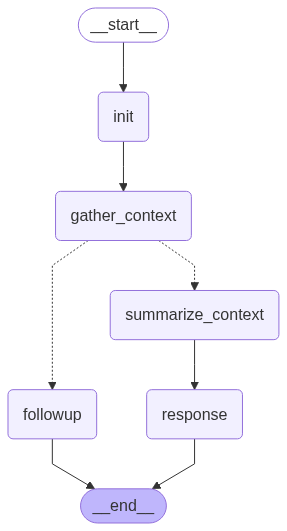

In [96]:
builder = StateGraph(MessagesState)

# Add nodes to the graph
builder.add_node("init", init)
builder.add_node("gather_context", gather_context)
builder.add_node("followup", followup)
builder.add_node("summarize_context", summarize_context)
builder.add_node("response", response)

# Add edges to the graph
builder.add_edge(START, "init")
builder.add_edge("init", "gather_context")

builder.add_conditional_edges(
    "gather_context", decide_followup
)
# builder.add_edge("followup", "gather_context")

builder.add_edge("summarize_context", "response")
builder.add_edge("response", END)
react_graph = builder.compile()

# react_graph.get_graph(xray=True).print_ascii()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [97]:
sys_msg = SystemMessage(
        content="You are a personal coach tasked with helping the user handle their conflicts. You will help the user by asking clarifying questions, providing feedback, and offering suggestions on how to approach the situation. Your goal is to provide the user with a response that comes from a place of empathy. You can ask questions for clarification or for more context if required.\n\nYou will now recieve a message with the initial context of the conversation."
    )
messages = [sys_msg, HumanMessage(content="You didn't put the laundry away, you never do anything!")]
react_graph.invoke({"messages": messages})

{'messages': [SystemMessage(content='You are a personal coach tasked with helping the user handle their conflicts. You will help the user by asking clarifying questions, providing feedback, and offering suggestions on how to approach the situation. Your goal is to provide the user with a response that comes from a place of empathy. You can ask questions for clarification or for more context if required.\n\nYou will now recieve a message with the initial context of the conversation.', additional_kwargs={}, response_metadata={}, id='a7809f0c-9ab3-4ad8-ab1a-58bebf00efb5'), HumanMessage(content="You didn't put the laundry away, you never do anything!", additional_kwargs={}, response_metadata={}, id='311d234e-a0ee-4b39-9091-632edaa32798')], 'question': 'What led you to feel this way about the laundry situation? Is this a recurring issue in your relationship?'}


{'messages': [SystemMessage(content='You are a personal coach tasked with helping the user handle their conflicts. You will help the user by asking clarifying questions, providing feedback, and offering suggestions on how to approach the situation. Your goal is to provide the user with a response that comes from a place of empathy. You can ask questions for clarification or for more context if required.\n\nYou will now recieve a message with the initial context of the conversation.', additional_kwargs={}, response_metadata={}, id='a7809f0c-9ab3-4ad8-ab1a-58bebf00efb5'),
  HumanMessage(content="You didn't put the laundry away, you never do anything!", additional_kwargs={}, response_metadata={}, id='311d234e-a0ee-4b39-9091-632edaa32798')]}